In [45]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("Results/NamedEntities.csv",encoding="utf-16")
data = data.drop("Unnamed: 0",axis=1)
data["Datetime"] = pd.to_datetime(data["Datetime"])

,Message ID,Text,Country,Datetime,NEs
0,1594,​​Упс.),Ukraine,2022-02-01 07:57:15,()
1,1595,ТЕОРИЯ ХАОСА\n\nhttps://apeiron.school/chaos-t...,Ukraine,2022-02-01 18:08:01,(ТЕОРИЯ ХАОСА\n\nhttps://apeiron.school/chaos-...
2,1598,​​- Завтра начинается очередной модуль курса «...,Ukraine,2022-02-04 09:50:46,"(​​-, Завтра)"
3,1599,​​- Politeka с неотразимой Ингой Мезерей:\n\n0...,Ukraine,2022-02-04 13:54:08,"(Politeka, Ингой Мезерей, Эрдогана, Украину, У..."
4,1600,​​- Она не спит. У неё - инсайт.)\n\nУченье - ...,Ukraine,2022-02-05 21:20:48,"(​​-,)"
...,...,...,...,...,...
220399,56079,"Текст предупреждений, которые полицейские прин...",Russia,2022-03-03 19:52:18,"(Дождя, ДАННОЕ СООБЩЕНИЕ (МАТЕРИАЛ), ВЫПОЛНЯЮЩ..."
220400,56080,NaN,Russia,2022-03-03 19:52:18,()
220401,56081,Смотрите фильм Веры Кричевской F@ck This Job в...,Russia,2022-03-05 16:14:44,"(Веры Кричевской, ДАННОЕ СООБЩЕНИЕ (МАТЕРИАЛ),..."
220402,56082,Важное заявление «Роскомсвободы». Проект проси...,Russia,2022-03-09 13:02:22,"(Роскомсвободы, Запад, России, ДАННОЕ СООБЩЕНИ..."


## Word2Vec embeddings approach

In [4]:
data_rus = data.loc[data["Country"] == "Russia"]
data_ukr = data.loc[data["Country"] == "Ukraine"]

In [21]:
# Preparing texts
def preprocess(data):
    texts = []
    for i,row in tqdm(data.iterrows()):
        text = row["Text"]
        if type(text) == float:
            continue
        tokenized = word_tokenize(text)
        texts.append(tokenized)
    return texts

In [22]:
texts_rus = preprocess(data_rus)
texts_ukr = preprocess(data_ukr)

73861it [00:38, 1899.47it/s]
146543it [01:10, 2072.93it/s]


In [25]:
# Trainig models
model_rus = Word2Vec(sentences=texts_rus, vector_size=100, window=5, min_count=1, workers=4)
model_ukr = Word2Vec(sentences=texts_ukr, vector_size=100, window=5, min_count=1, workers=4)

In [35]:
def distance(vec1, vec2):
    return np.linalg.norm(vec1-vec2)

def event_matching_w2v_pipeline(date, timespan, keyword, datasets, models):
    subset_a = datasets[0][(dataset_a.Datetime > date - datetime.timedelta(days=timespan)) &
                         (dataset_a.Datetime < date + datetime.timedelta(days=timespan))]
    subset_a = subset_a[~subset_a.Text.isnull()]
    subset_a = subset_a[subset_a.Text.str.contains(keyword, case=False)]

    subset_b = datasets[1][(dataset_b.Datetime > date - datetime.timedelta(days=timespan)) &
                         (dataset_b.Datetime < date + datetime.timedelta(days=timespan))]
    subset_b = subset_b[~subset_b.Text.isnull()] 
    subset_b = subset_b[subset_b.Text.str.contains(keyword, case=False)]
    
    sentence_matching_scores_1 = []
    sentence_matching_scores_2 = []
    
    keyword_vector_1 = models[0].wv[keyword]
    for sent_a in tqdm(subset_a.Text.values):
        vectors = []
        for word in word_tokenize(sent_a):
            vectors.append(models[0].wv[word])
        mean_vector = np.mean(np.array(vectors),axis=0)
        score = distance(mean_vector,keyword_vector_1)
        sentence_matching_scores_1.append([sent_a,score,mean_vector])
        
    keyword_vector_2 = models[1].wv[keyword]
    for sent_b in tqdm(subset_b.Text.values):
        vectors = []
        for word in word_tokenize(sent_b):
            vectors.append(models[1].wv[word])
        mean_vector = np.mean(np.array(vectors),axis=0)
        score = distance(mean_vector,keyword_vector_2)
        sentence_matching_scores_2.append([sent_a,score,mean_vector])
    
    return sentence_matching_scores_1, sentence_matching_scores_2
    

In [36]:
date = datetime.datetime(2022, 4, 2, 0, 0)
timespan = 2
keyword = "Буча"
dataset_a = data_ukr
dataset_b = data_rus
 
results = event_matching_w2v_pipeline(date, timespan, keyword, [dataset_a, dataset_b], [model_ukr,model_rus])


100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 533.32it/s]


In [41]:
# Check

ukr_candidates = results[0]
rus_candidates = results[1]

top_ukr_score = np.inf

for cand in ukr_candidates:
    if cand[1] < top_ukr_score:
        top_ukr_score = cand[1]
        ukr_text = cand[0]
        ukr_vec = cand[2]

top_rus_score = np.inf
        
for cand in rus_candidates:
    if cand[1] < top_rus_score:
        top_rus_score = cand[1]
        rus_text = cand[0]
        rus_vec = cand[2]
        
        
print("Ukraine text:")
print(ukr_text)
print("Score:",top_ukr_score)
print()
print("Russia text:")
print(rus_text)
print("Score:",top_rus_score)

Ukraine text:
☝️Київська область. Які напрямки залишаються найбільш небезпечними:

🔸населені пункти вздовж Житомирської траси
🔸Буча – Ворзель – Гостомель
🔸Немішаєве
🔸Дмитрівська громада
🔸Макарівська громада
🔸північ Вишгородського району
🔸території деяких населених пунктів Баришівської, Калитнянської, Великодимерської громад
Score: 6.702515

Russia text:
❗️ Изнасилования, казни, грабежи: Human Rights Watch документирует военные преступления рашистов в Укриане.

В частности, на данный момент зафиксировали зверства на территориях Черниговской, Харьковской и Киевской областей, а так же  в городе Буча.

"Случаи, которые мы задокументировали, представляют собой неописуемую, умышленную жестокость и насилие в отношении гражданского населения Украины. Изнасилования, убийства и другие насильственные действия в отношении людей, находящихся под стражей российских войск, следует расследовать как военные преступления", - сказал Хью Уильямсон, директор Human Rights Watch в Европе и Центральной Азии



[1.00000000e+00 2.30228909e-32]


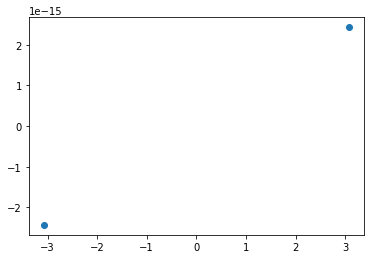

In [49]:
X = [ukr_vec,rus_vec]
pca = PCA(n_components=2)
transformed = pca.fit(X)
print(pca.explained_variance_ratio_)
transformed = pca.transform(X)
x,y = transformed.T
plt.scatter(x,y)
plt.show()